In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [2]:
from helpers import load_data, preprocess_data

path_dataset = "movielens100k.csv"
ratings = load_data(path_dataset)

number of items: 1682, number of users: 943


### Plot the number of ratings per movie and user

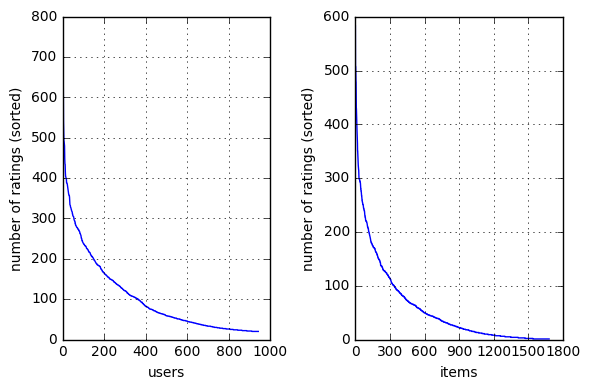

min # of items per user = 20, min # of users per item = 1.


In [3]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [4]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(998)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  
    
    xs, ys = valid_ratings.nonzero()
    indices = list(zip(xs, ys))
    np.random.shuffle(indices)
    
    cut = int(p_test * len(indices))
    train = valid_ratings.copy()
    xs, ys = zip(*indices)
    train[xs[:cut], ys[:cut]] = 0
    test = valid_ratings.copy()
    test[xs[cut:], ys[cut:]] = 0
    
    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

Total number of nonzero elements in origial data:99999
Total number of nonzero elements in train data:88157
Total number of nonzero elements in test data:9795


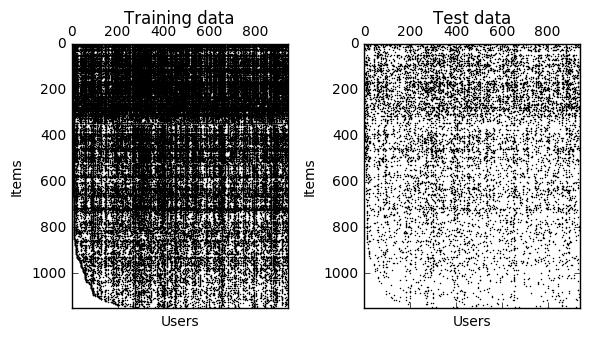

In [5]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
plot_train_test_data(train, test)

## Implementing Baselines 

### Use the global mean to do the prediction

In [6]:
from helpers import calculate_mse

def baseline_global_mean(train, test):
    """baseline method: use the global mean."""
    avg = test.copy()
    avg[avg.nonzero()] = train.sum() / train.size 
    return np.sqrt(2 * calculate_mse(test, avg).sum() / avg.size)

baseline_global_mean(train, test)

3.2550682134098907

### Use the user means as the prediction

In [7]:
def baseline_user_mean(train, test):
    """baseline method: use the user means as the prediction."""
    avg = test.copy()
    xs, ys = avg.nonzero()
    for i in np.arange(train.shape[0]):
        avg[i, ys] = train[i, :].sum() / len(ys)    
    return np.sqrt(2 * calculate_mse(avg, test).sum() / avg.size)

baseline_user_mean(train, test)

1.4782366847880071

### Use the item means as the prediction

In [8]:
def baseline_item_mean(train, test):
    """baseline method: use item means as the prediction."""
    avg = test.copy()
    xs, ys = avg.nonzero()
    for u in np.arange(train.shape[1]):
        avg[xs, u] = train[:, u].sum() / len(xs)    
    return np.sqrt(2 * calculate_mse(avg, test).sum()  / avg.size)
    
baseline_item_mean(train, test)

0.52800381710963429

### Learn the Matrix Factorization using SGD

#### Initialize matrix factorization

In [9]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    num_item, num_user = train.shape
    item_features = np.random.random((num_features, num_item)) * 5 # W
    user_features = np.random.random((num_features, num_user)) * 5 # Z
    return user_features, item_features

Compute the cost by the method of matrix factorization.


In [10]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    return np.sum(np.square(data - item_features.T @ user_features) / 2) / nz

In [11]:
user_features, item_features = init_MF(train, 20)
compute_error(test, user_features, item_features, test.size)

907082.78167543397

learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1477.218994776909.
iter: 1, RMSE on training set: 791.9956418161173.
iter: 2, RMSE on training set: 680.5832505865208.
iter: 3, RMSE on training set: 638.5024760490868.
iter: 4, RMSE on training set: 614.7966526101192.
iter: 5, RMSE on training set: 600.8545448591437.
iter: 6, RMSE on training set: 591.7787726822542.
iter: 7, RMSE on training set: 584.9084968490656.
iter: 8, RMSE on training set: 579.7233642335893.
iter: 9, RMSE on training set: 576.1804270989862.
iter: 10, RMSE on training set: 573.3471313383811.
iter: 11, RMSE on training set: 571.1640806165027.
iter: 12, RMSE on training set: 569.3529710223977.
iter: 13, RMSE on training set: 567.9988954475785.
iter: 14, RMSE on training set: 566.7930314699145.
iter: 15, RMSE on training set: 565.8598989663305.
iter: 16, RMSE on training set: 565.0728987242494.
iter: 17, RMSE on training set: 564.4895853961049.
iter: 18, RMSE on training set: 564.000864317001

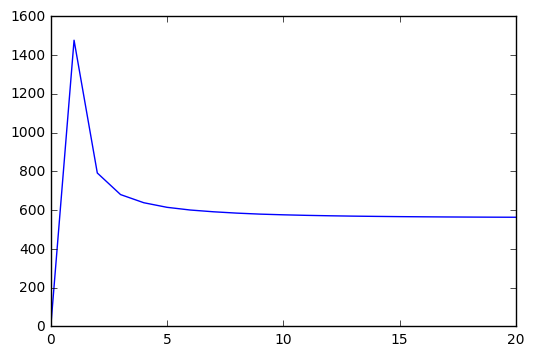

In [12]:
def matrix_factorization_SGD(train, test):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.01
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    num_epochs = 20     # number of full passes through the train set
    errors = [0]
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))
    
    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2
        
        for d, n in nz_train:
            e = train[d, n] - user_features[:, n].T @ item_features[:, d]
            
            dw = e * user_features[:, n]
            dz = e * item_features[:, d]
            item_features[:, d] += gamma * (dw - lambda_item * e) 
            user_features[:, n] += gamma * (dz - lambda_user * e)
            
            #item_features[:, d] += gamma * (dw - lambda_item * np.linalg.norm(item_features) * 0.001) 
            #user_features[:, n] += gamma * (dz - lambda_user * np.linalg.norm(user_features) * 0.001)
            
        rmse = compute_error(train, user_features, item_features, train.size)
        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        
        errors.append(rmse)
    
    rmse = compute_error(test, user_features, item_features, test.size)
    print("RMSE on test data: {}.".format(rmse))
    plt.plot(errors)
    plt.show()
    
matrix_factorization_SGD(train, test)   

### Learn the Matrix Factorization using Alternating Least Squares

In [13]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix."""
    w = item_features
    return np.linalg.inv(w @ w.T + np.identity(w.shape[0]) * lambda_user) @ (w @ train) 

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices):
    """update item feature matrix."""
    z = user_features
    return np.linalg.inv(z @ z.T + np.identity(z.shape[0]) * lambda_item) @ (z @ train.T)

4.4235371803
3.73721619714
3.64851388508
3.62024172447
3.60678000027
3.59898540866
3.5938227135
3.59004808902
3.58712889208
3.58482219116
3.58299509436
3.58155485255
3.58042608073
3.57954498104
3.57885817849
3.57832210878
3.57790205994
3.57757091098
3.57730778015
3.57709675063
3.57692576411
3.57678571137
3.57666971222
3.57657256009


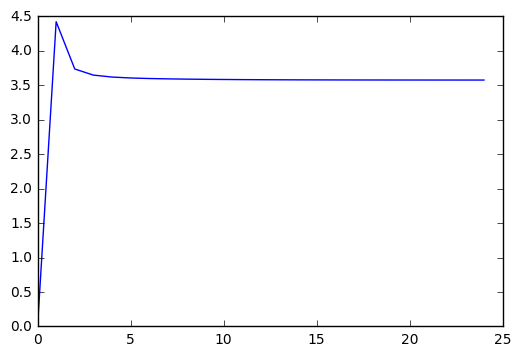

In [14]:
from helpers import build_index_groups


def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    stop_criterion = 1e-4
    change = 1
    error_list = [0]
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    
    rmse = compute_error(train, user_features, item_features, train.size)

    while True:
        item_features = update_item_feature(train, user_features, lambda_item, 1, 1)
        user_features = update_user_feature(train, item_features, lambda_user, 1, 1)
        
        rmse = compute_error(train, user_features, item_features, train.size)
        error_list.append(rmse)
        print(rmse)
        if abs(error_list[-2] - error_list[-1]) < stop_criterion:
            break
        
    plt.plot(error_list)
    plt.show()

ALS(train, test)